In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.decomposition import PCA
import joblib

In [2]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [3]:
path_files = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

# Extract region and compute PCs

In [4]:
def extract_region(data_array, regioncoords):
    """
    Extract a region from a DataArray with longitudes ranging from 0 to 360.
    Rearrange the data to have continuous longitudes even if the region wraps around 0 or 360 degrees.
    
    Parameters:
    data_array (xr.DataArray): Input DataArray with coordinates 'lon' (0 to 360) and 'lat'.
    min_lon (float): Minimum longitude of the region.
    max_lon (float): Maximum longitude of the region.
    min_lat (float): Minimum latitude of the region.
    max_lat (float): Maximum latitude of the region.
    
    Returns:
    xr.DataArray: Extracted region with continuous coordinates.
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords

    # Handle the case where the region crosses the prime meridian or the International Date Line
    if min_lon > max_lon:
        # Split the region into two parts: one on the left of 0° and one on the right
        region1 = data_array.sel(
            lon=slice(min_lon, 360), 
            lat=slice(min_lat, max_lat)
        )
        region2 = data_array.sel(
            lon=slice(0, max_lon), 
            lat=slice(min_lat, max_lat)
        )

        # Combine the two parts along the longitude axis
        combined_region = xr.concat([region1, region2], dim='lon')

    else:
        # Directly slice the region
        combined_region = data_array.sel(
            lon=slice(min_lon, max_lon), 
            lat=slice(min_lat, max_lat)
        )

    # # Sort the longitudes to ensure they are in the correct order
    # combined_region = combined_region.sortby('lon')

    return combined_region

def compute_pcs(dataarray):
    dataflattened = dataarray.Z_anom.stack(flat=('lat','lon')).transpose('time','flat')
    pca_obj = PCA(12, whiten=True)
    pca_obj = pca_obj.fit(dataflattened)
    datatransformed = pca_obj.transform(dataflattened)

    variance_explained = np.sum(pca_obj.explained_variance_ratio_) * 100
    return datatransformed, variance_explained, pca_obj

In [5]:
path_files

'/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

In [7]:
path_pcs = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/PCs_Z500/'

In [10]:
for reanalysis in names_reanalyses:
    anoms = xr.open_dataset(f'{path_files}Z500Anoms_{reanalysis}.nc')
    aaa

NameError: name 'aaa' is not defined

In [9]:
for reanalysis in names_reanalyses:
    anoms = xr.open_dataset(f'{path_files}Z500Anoms_{reanalysis}.nc')
    aaa
    pcs, variance_explained_temp, pca_obj = compute_pcs(anoms)
    print(reanalysis, variance_explained_temp)
    # filename = f'{path_pcs}PCs_{reanalysis}.pca_obj'
    # joblib.dump(pca_obj, filename)

    # pcs = pd.DataFrame(pcs,index = anoms.time)
    # pcs = pcs[:'2023-12-31']
    # pcs.to_csv(f'{path_pcs}/PCs_{reanalysis}.csv')

ERA5 83.59779651436774
JRA3Q 83.61493183018773
NCEP_NCAR 83.51834322078166


# plot PCs

In [10]:
import matplotlib.pyplot as plt

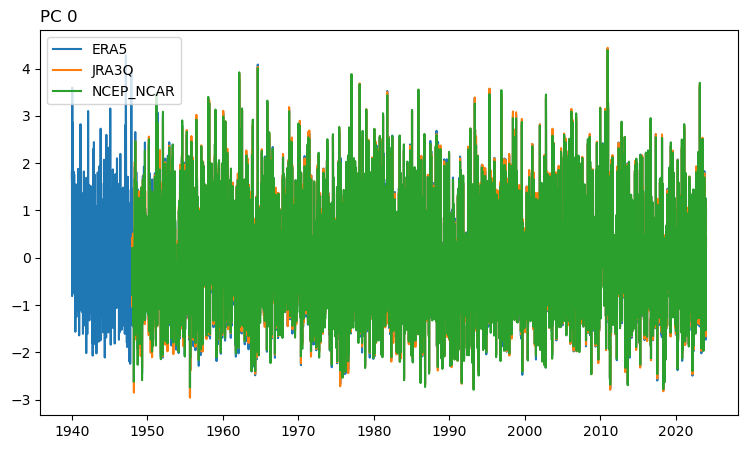

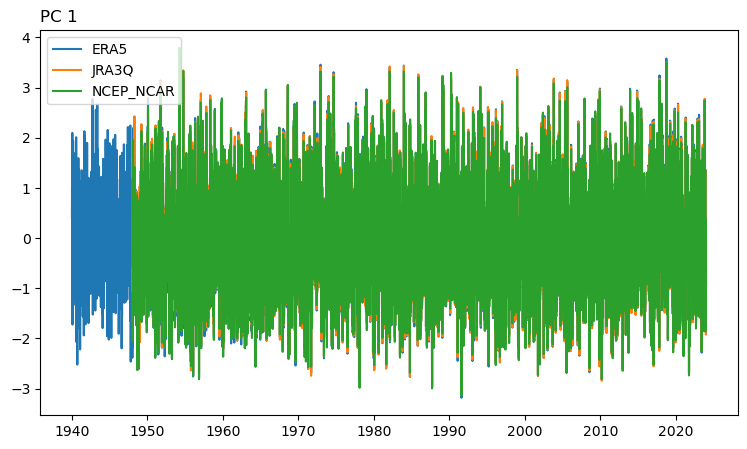

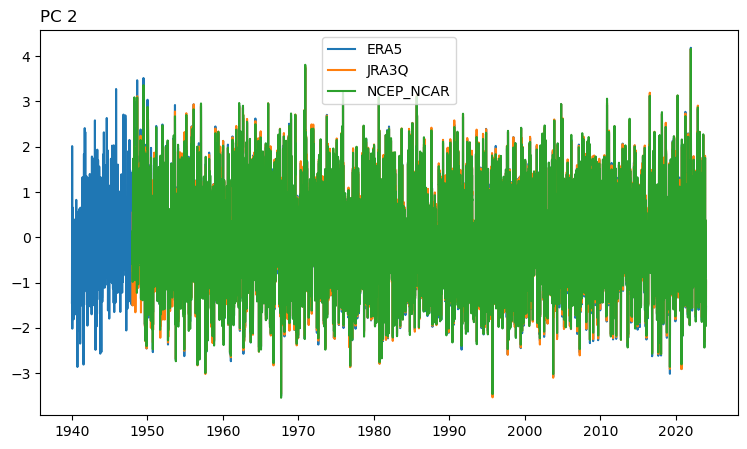

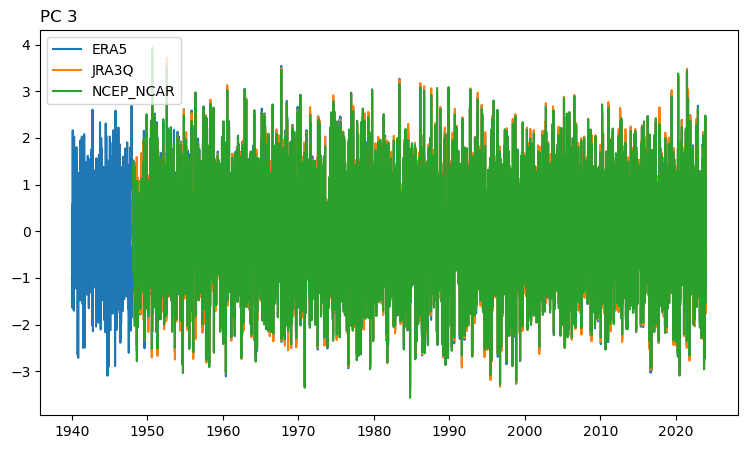

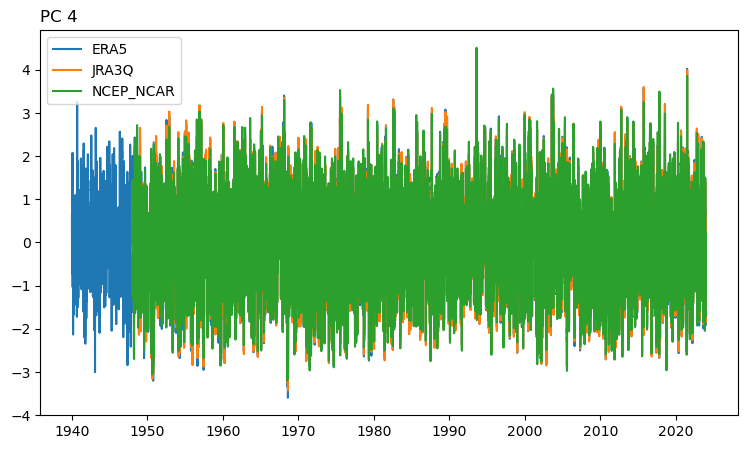

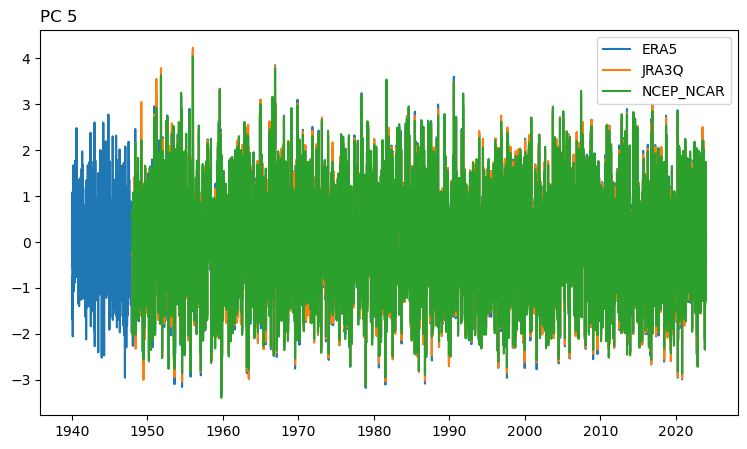

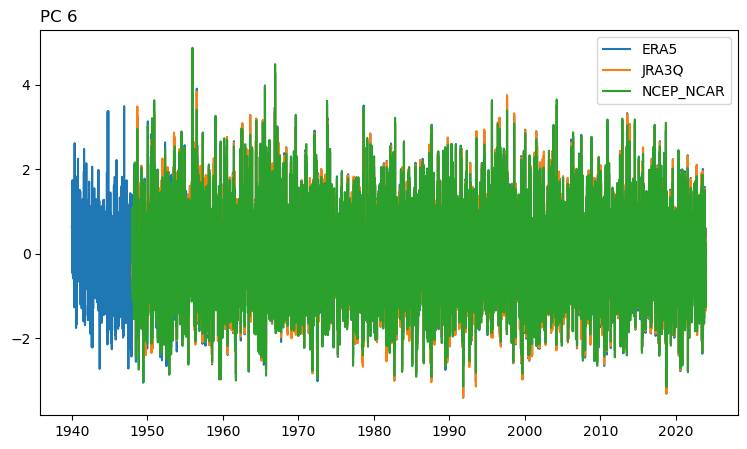

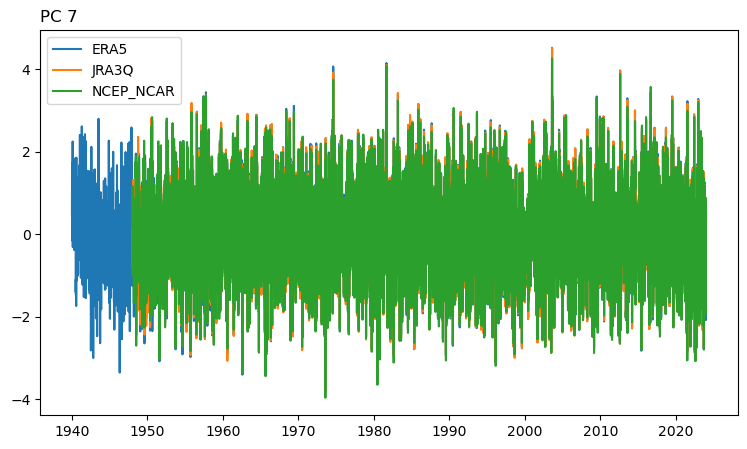

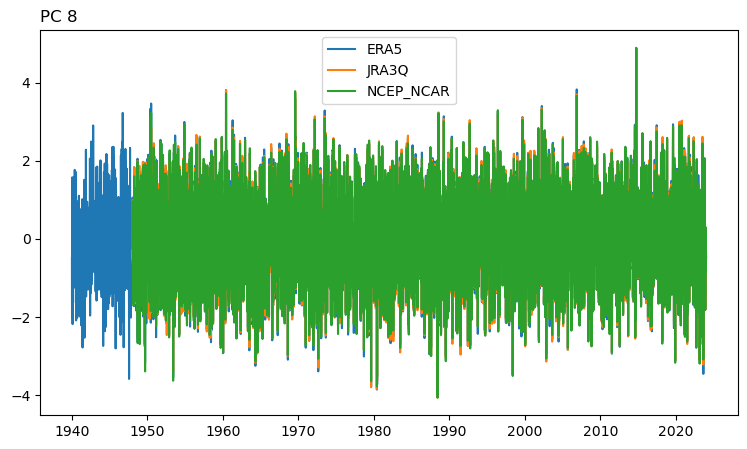

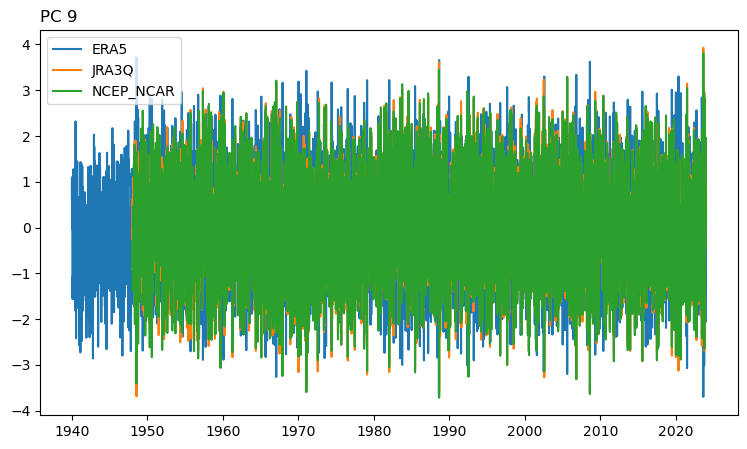

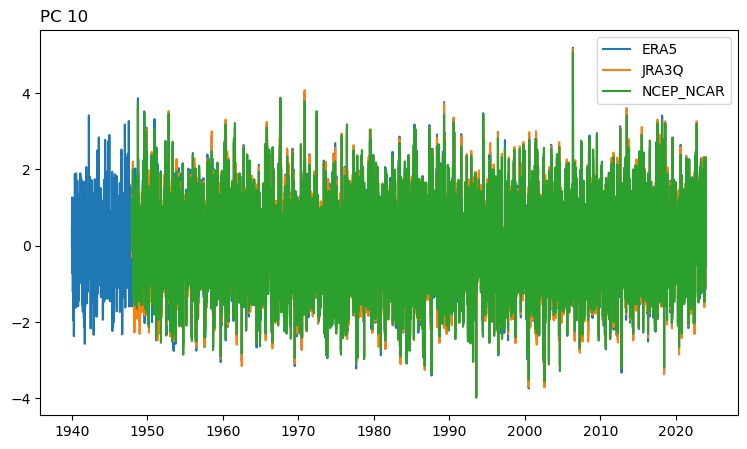

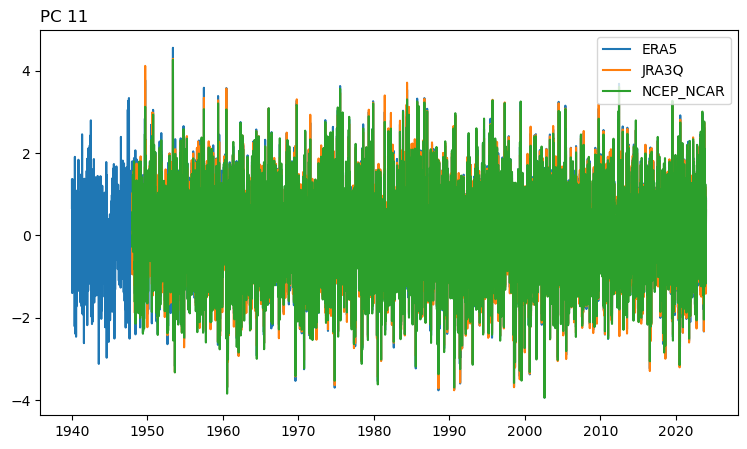

In [11]:
dic_pcs = {}
for reanalysis in names_reanalyses:
    dic_pcs[reanalysis] = pd.read_csv(f'{path_pcs}/PCs_{reanalysis}.csv', index_col=0, parse_dates=True, names=np.arange(0,12),skiprows=1)

for pc in range(0,12):
    plt.figure(figsize=(9,5))
    for reanalysis in names_reanalyses:
        plt.plot(dic_pcs[reanalysis][pc],label=reanalysis)
    plt.title(f'PC {pc}',loc='left')
    plt.legend()
    plt.show()
    plt.close('all')

In [12]:
import seaborn as sns

# Function to align and compute correlation matrix
def compute_correlation_matrix(pc):
    df_combined = pd.DataFrame()
    for reanalysis in names_reanalyses:
        df_combined[reanalysis] = dic_pcs[reanalysis][pc]
    
    # Drop rows with NaN values to align the series
    df_combined.dropna(inplace=True)
    return df_combined.corr()

In [13]:
import copy
dic_pcs_corrected = copy.deepcopy(dic_pcs)

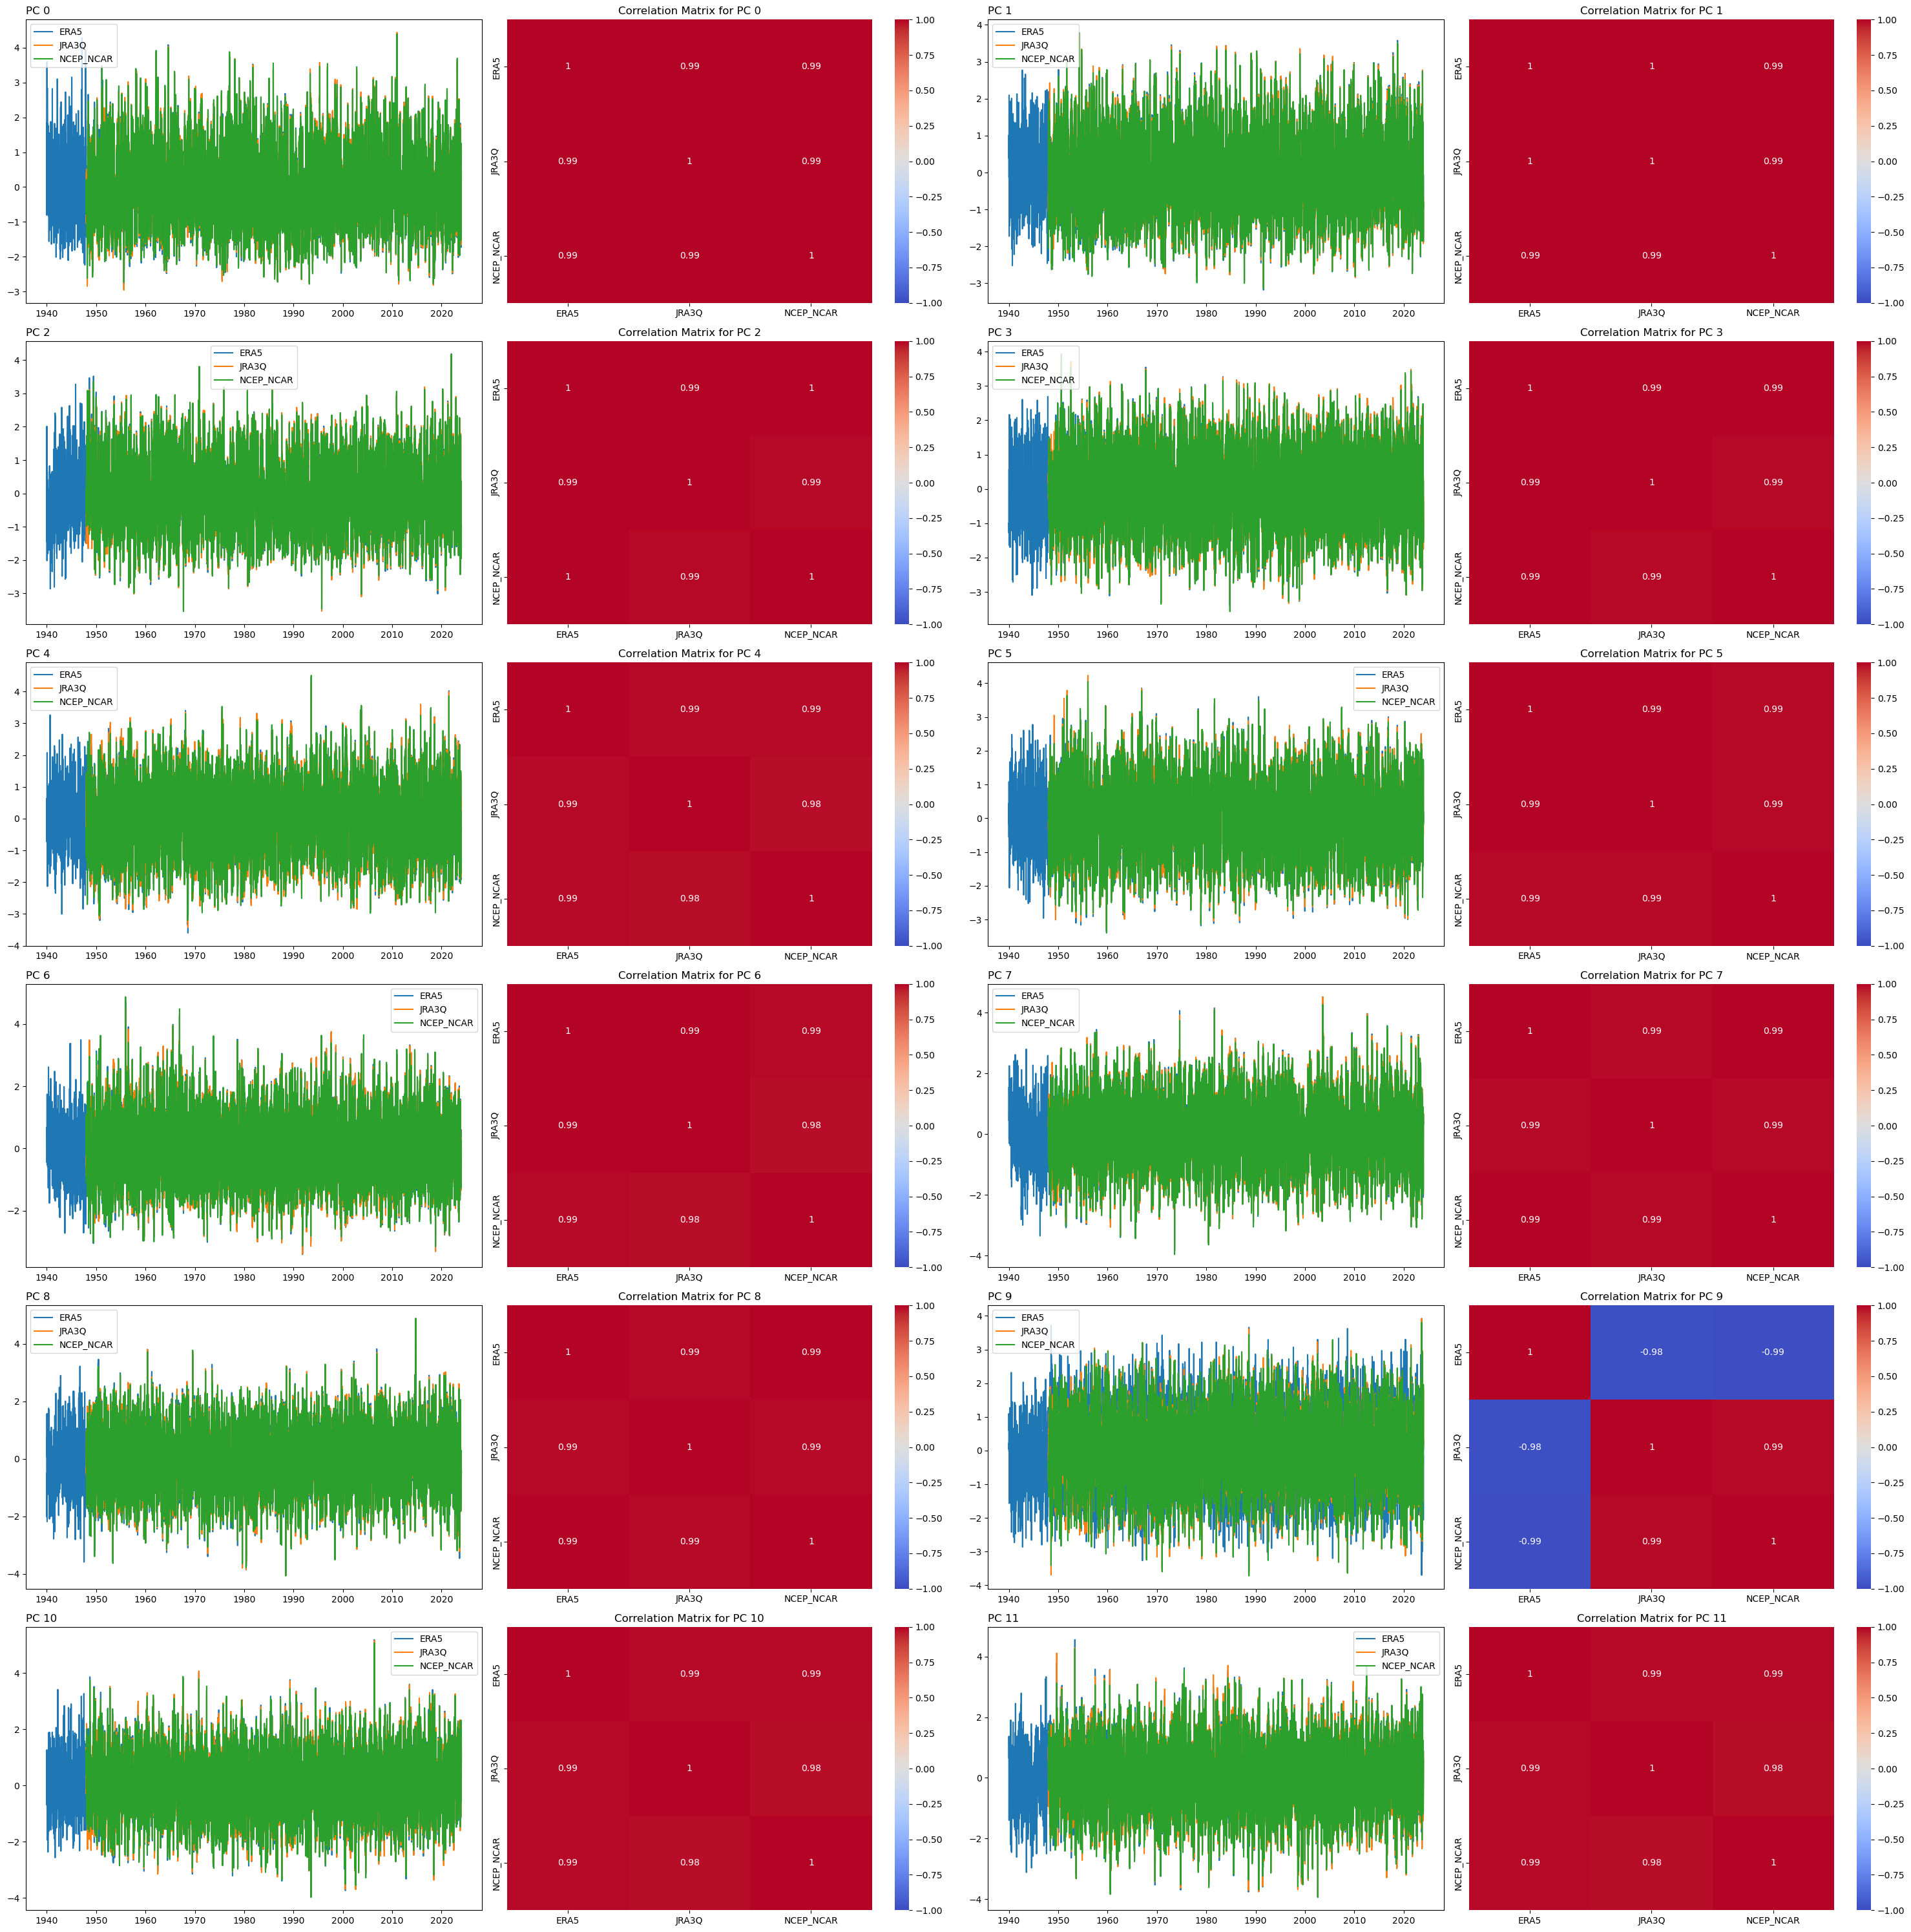

In [14]:
# Define the number of rows and columns
n_rows = 6
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols*2, figsize=(30, 30))

# Plotting
for pc in range(12):
    row = pc // n_cols
    col = (pc % n_cols) * 2
    
    # Plot time series
    ax1 = axes[row, col]
    for reanalysis in names_reanalyses:
        ax1.plot(dic_pcs[reanalysis][pc], label=reanalysis)
    ax1.set_title(f'PC {pc}', loc='left')
    # if row == 0 and col == 0:  # Add legend to the first subplot
    ax1.legend()
    
    # Compute and plot correlation matrix
    corr_matrix = compute_correlation_matrix(pc)
    ax2 = axes[row, col + 1]
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
    ax2.set_title(f'Correlation Matrix for PC {pc}')

plt.tight_layout()
plt.show()

In [15]:
dic_pcs_corrected['JRA3Q'][9] = -dic_pcs_corrected['JRA3Q'][9].values
dic_pcs_corrected['NCEP_NCAR'][9] = -dic_pcs_corrected['NCEP_NCAR'][9].values

In [16]:
for reanalysis in names_reanalyses:
    pcs = dic_pcs_corrected[reanalysis]
    pcs.to_csv(f'{path_pcs}/PCs_{reanalysis}_corrected.csv')

# plot PCs

In [17]:
import matplotlib.pyplot as plt

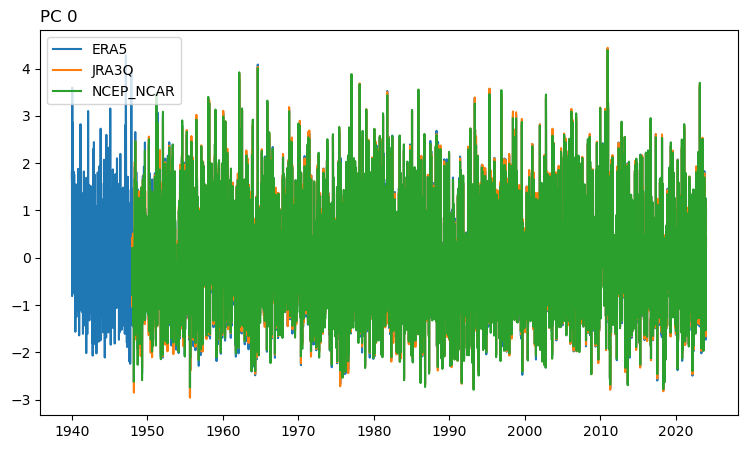

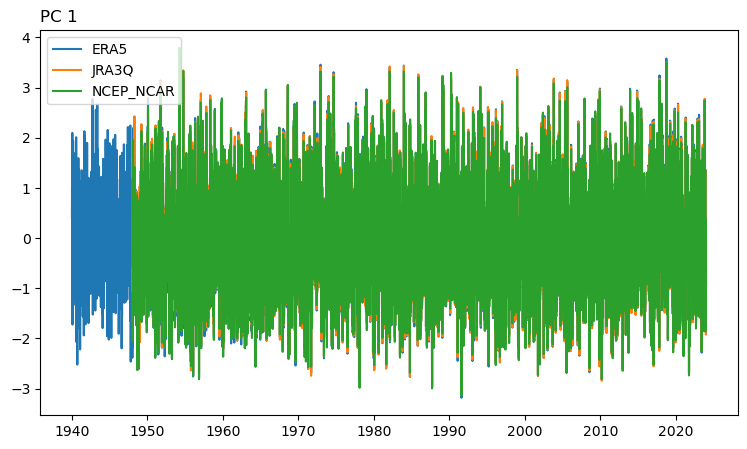

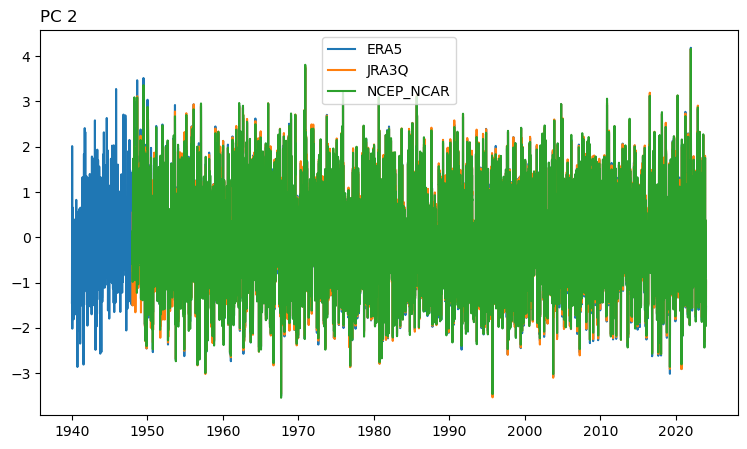

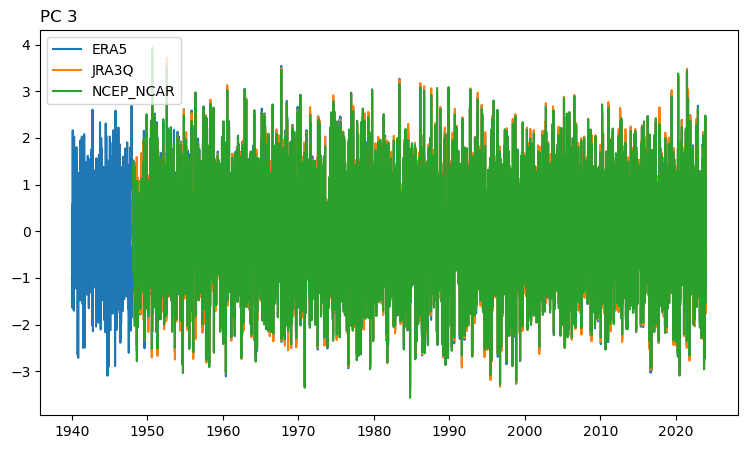

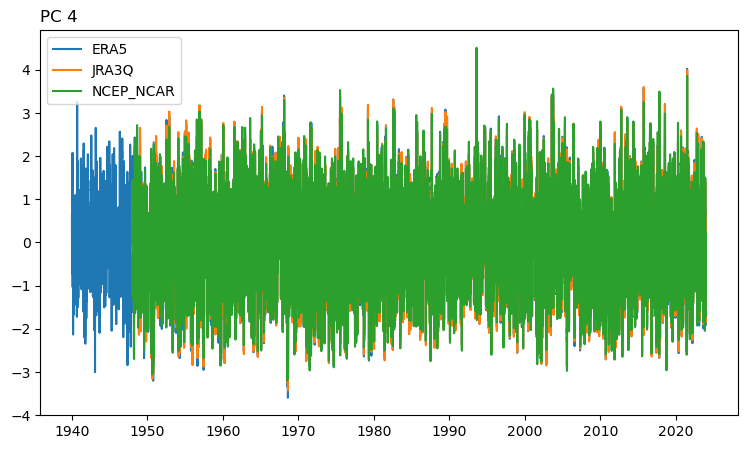

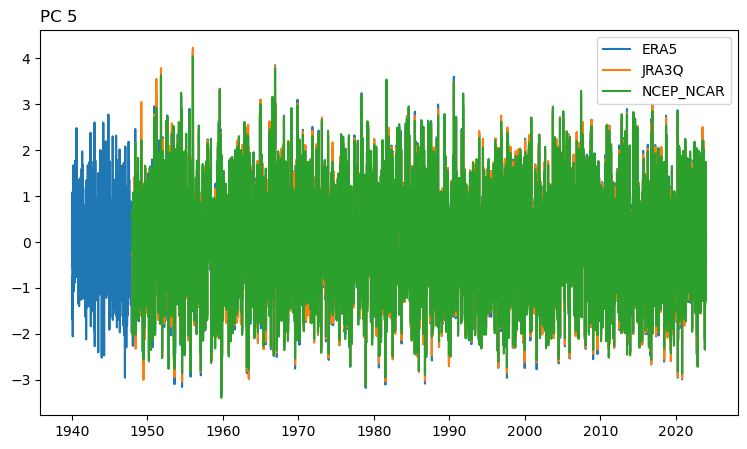

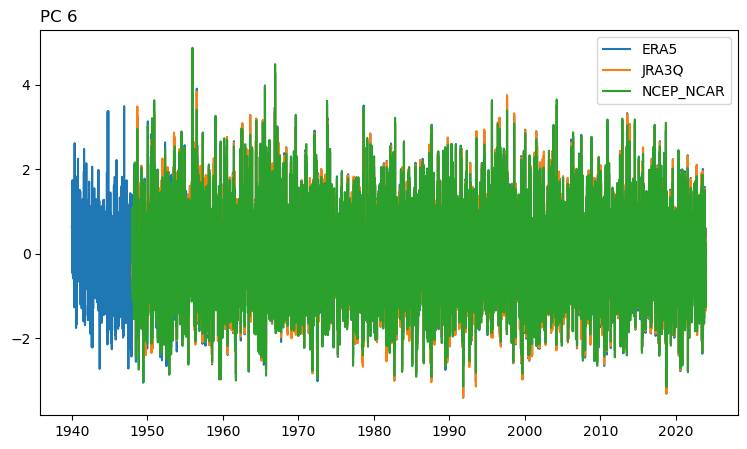

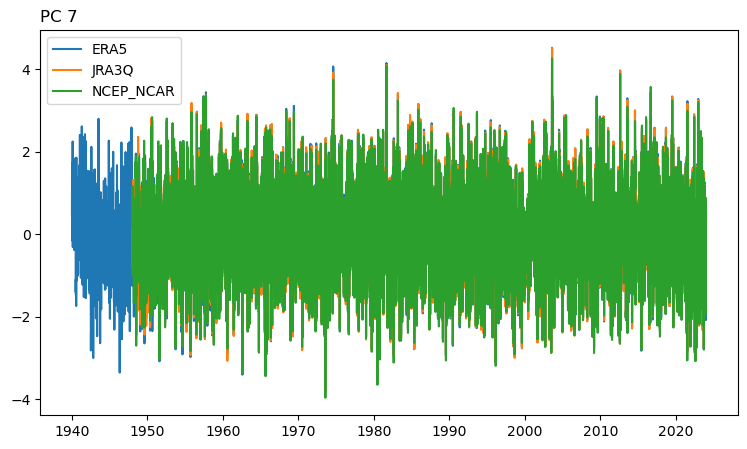

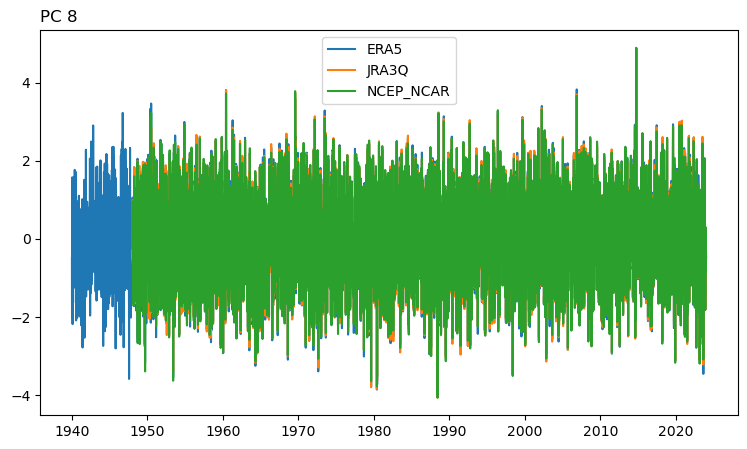

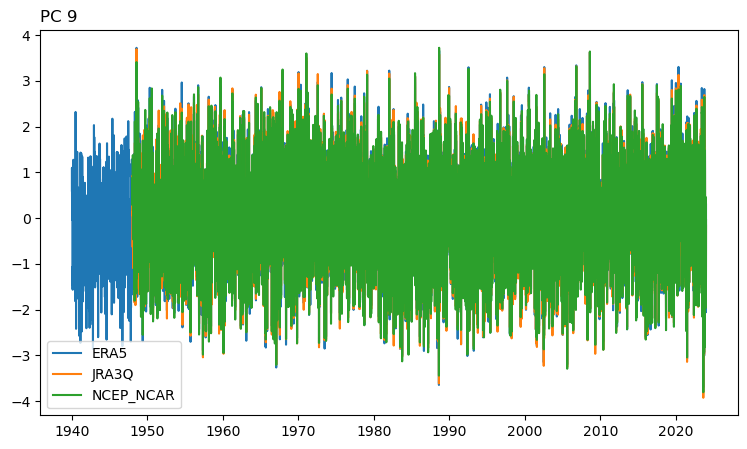

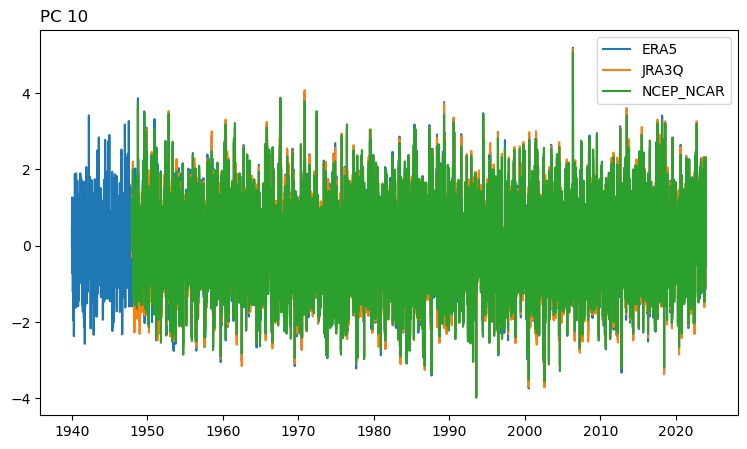

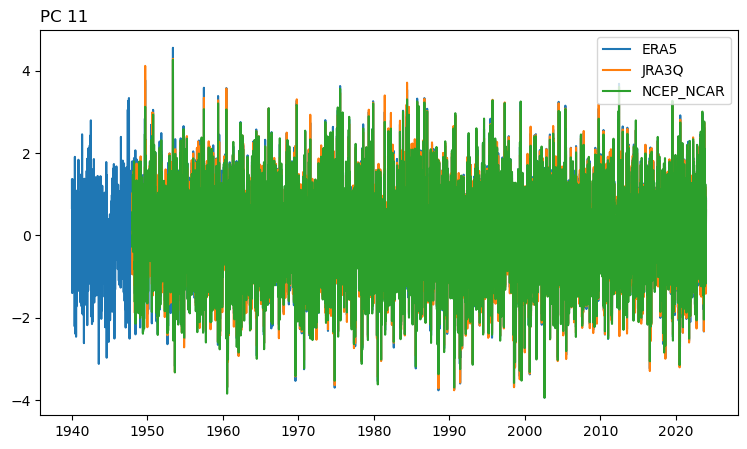

In [18]:
dic_pcs = {}
for reanalysis in names_reanalyses:
    dic_pcs[reanalysis] = pd.read_csv(f'{path_pcs}/PCs_{reanalysis}_corrected.csv', index_col=0, parse_dates=True, names=np.arange(0,12),skiprows=1)

for pc in range(0,12):
    plt.figure(figsize=(9,5))
    for reanalysis in names_reanalyses:
        plt.plot(dic_pcs[reanalysis][pc],label=reanalysis)
    plt.title(f'PC {pc}',loc='left')
    plt.legend()
    plt.show()
    plt.close('all')

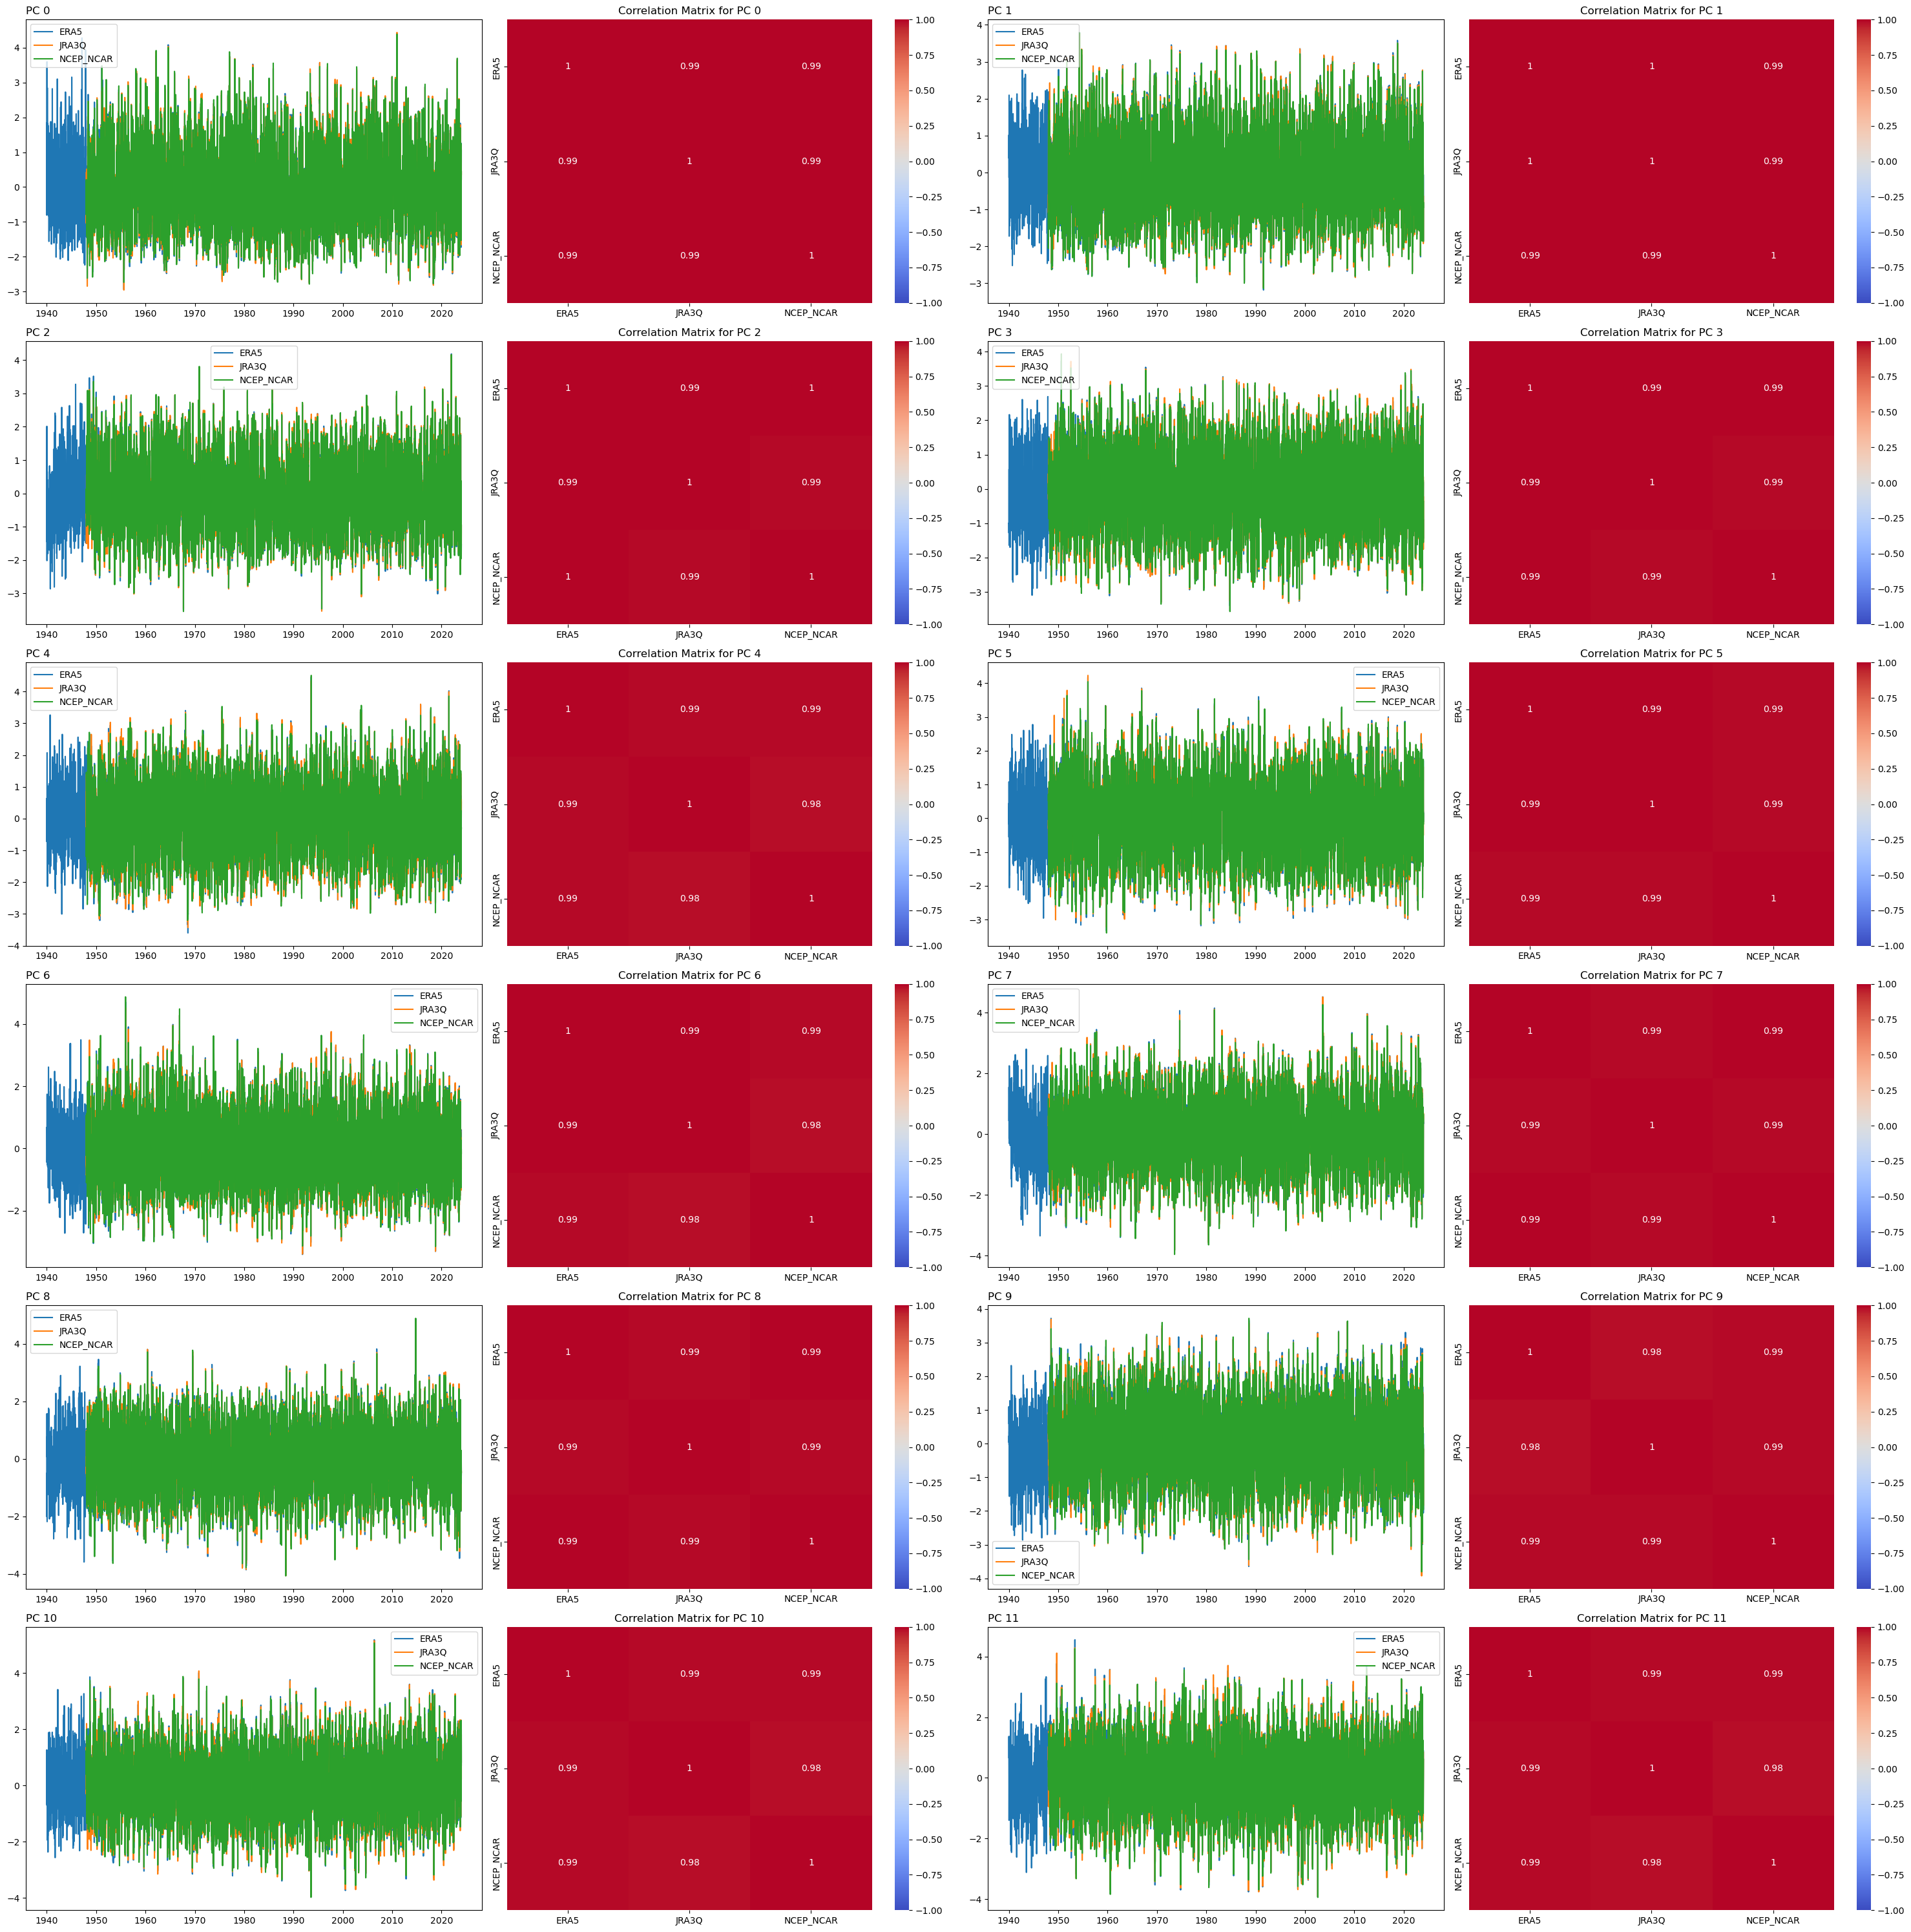

In [19]:
# Define the number of rows and columns
n_rows = 6
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols*2, figsize=(30, 30))

# Plotting
for pc in range(12):
    row = pc // n_cols
    col = (pc % n_cols) * 2
    
    # Plot time series
    ax1 = axes[row, col]
    for reanalysis in names_reanalyses:
        ax1.plot(dic_pcs[reanalysis][pc], label=reanalysis)
    ax1.set_title(f'PC {pc}', loc='left')
    # if row == 0 and col == 0:  # Add legend to the first subplot
    ax1.legend()
    
    # Compute and plot correlation matrix
    corr_matrix = compute_correlation_matrix(pc)
    ax2 = axes[row, col + 1]
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
    ax2.set_title(f'Correlation Matrix for PC {pc}')

plt.tight_layout()
plt.show()